# Importing libraries

In [19]:
import pandas as pd
import re
import mtranslate
from langdetect import detect
import seaborn as sb
import matplotlib.pyplot as plt

# Data profiling and exploratory

In [37]:
df=pd.read_csv('Github_data.csv')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365000 entries, 0 to 364999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        365000 non-null  int64 
 1   created_at        365000 non-null  object
 2   full_name         365000 non-null  object
 3   language          323705 non-null  object
 4   description       264824 non-null  object
 5   topics            365000 non-null  object
 6   stargazers_count  365000 non-null  int64 
 7   forks_count       365000 non-null  int64 
 8   owner             365000 non-null  object
 9   license           165865 non-null  object
dtypes: int64(3), object(7)
memory usage: 27.8+ MB


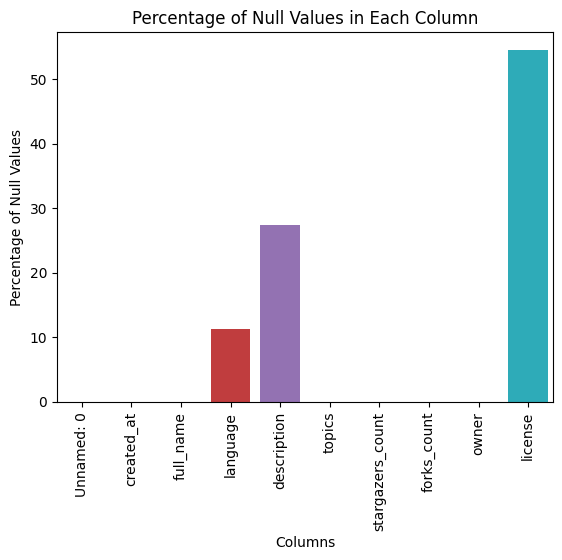

In [22]:
# Calculate percentage of null values for each column
null_percentages = (df.isnull().sum() / len(df)) * 100

# Create a bar plot using Seaborn
sb.barplot(x=null_percentages.index, y=null_percentages.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.title('Percentage of Null Values in Each Column')
plt.show()

# Cleaning

## Data type correction

In [23]:
df['created_at']=pd.to_datetime(df['created_at'])

## Renaming columns

In [24]:
# Define the new column names
new_columns = {'created_at': 'project_date',
               'full_name': 'name',
               'language': 'technology',
               'description': 'description',
               'topics': 'topics',
               'stargazers_count': 'stars',
               'forks_count': 'forks',
               'owner': 'owner',
               'license': 'licence'}

# Rename the columns using the rename() method
df = df.rename(columns=new_columns)

## Drop null technology lines and remove duplicated

In [25]:
df.dropna(subset=['technology'],inplace=True)
df.drop_duplicates(inplace=True)

In [26]:
df['topics'] = df['topics'].replace('[]', "['No topics']")
df['description'] = df['description'].fillna('No description') 
df['licence'] = df['licence'].fillna('Without') 

## Detect outliers

In [27]:
df[['stars','forks']].describe()

,stars,forks
count,323705.000000,323705.000000
mean,32.821581,6.164545
std,532.767999,127.522524
min,2.000000,0.000000
25%,4.000000,0.000000
50%,6.000000,1.000000
75%,12.000000,2.000000
max,140740.000000,31199.000000


## Fixing outliers

In [28]:
#stars
w_Q1=df['stars'].quantile(0.25)
w_Q3=df['stars'].quantile(0.75)

w_IQR=w_Q3-w_Q1

w_Upper_Whisker = w_Q3 + 1.5 * w_IQR

df = df[(df['stars'] <= w_Upper_Whisker)]

#froks
w_Q1=df['forks'].quantile(0.25)
w_Q3=df['forks'].quantile(0.75)

w_IQR=w_Q3-w_Q1

w_Upper_Whisker = w_Q3 + 1.5 * w_IQR

df = df[(df['forks'] <= w_Upper_Whisker)]

df.shape
df[['stars','forks']].describe()

,stars,forks
count,266138.000000,266138.000000
mean,6.697195,0.835799
std,4.379284,1.237750
min,2.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,8.000000,1.000000
max,24.000000,5.000000


## Add interest index column

In [29]:
#new columns
df['interest_indicator']=df['stars']*0.4+df['forks']*0.6
df[['interest_indicator']].describe()

,interest_indicator
count,266138.000000
mean,3.180358
std,2.097265
min,0.800000
25%,1.600000
50%,2.400000
75%,4.000000
max,12.600000


## Removing unnecessary columns

In [30]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

# Fixing description problems => emojis & traduction

In [31]:
### delete special car
def remove_emojis(text):
    if isinstance(text, str):
        return re.sub(r'[\U0001F000-\U0001FFFF]|[\U00010000-\U0010FFFF]|[\u2600-\u26FF]|\uD83C[\uDF00-\uDFFF]|\uD83D[\uDC00-\uDE4F]|\uD83D[\uDE80-\uDEFF]|\uD7C9[\uDC00-\uDDFF]', '', text)
    else:
        return text
    
df['description']=df['description'].apply(remove_emojis)

In [ ]:
### translate
def to_english(text):
    if text=='No description' or detect(text)=='en':
        return text
    else:
        return mtranslate.translate(text)

df['description']=df['description'].apply(to_english)

In [32]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266138 entries, 199 to 364999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   project_date        266138 non-null  datetime64[ns, UTC]
 1   name                266138 non-null  object             
 2   technology          266138 non-null  object             
 3   description         266138 non-null  object             
 4   topics              266138 non-null  object             
 5   stars               266138 non-null  int64              
 6   forks               266138 non-null  int64              
 7   owner               266138 non-null  object             
 8   licence             266138 non-null  object             
 9   interest_indicator  266138 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(6)
memory usage: 22.3+ MB


# Save dataset to CSV file

In [35]:
df.to_csv('cleaned_github_data.csv')